### Dependency Imports

In [1]:
# External
import pandas as pd
import torch
import torch.nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import winsound 

# Local
from DataParser import Pipeline
from TRN import TRN
from VisualizationHelpers import VizHelp

#### Model Instantiation

In [10]:
# Define Model Parameters
input_dim = 1
hidden_dim = 32
num_layers = 2
decoder_steps = 3
num_epochs = 30
use_deltas = False
output_dim = 1

# File Locations
file_idx = 0
input_files = ["ibm.us.txt", "aapl.us.txt", "googl.us.txt"]
input_path = "input/Data/Stocks/" + input_files[file_idx]

# Create Pipeline
pipeline = Pipeline(input_path, num_decoders=decoder_steps, use_deltas=use_deltas)

# Instantiate the Model
model = TRN(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim, num_decoders=decoder_steps)

Using Raw Input:


#### Check for Hardware Acceleration

In [3]:
if torch.cuda.is_available:
    print("CUDA device detected, utilizing GPU")
    device = torch.device('cuda')
else:
    print("CUDA device detected, defaulting to CPU")
    device = torch.device('cpu')

model.to(device)

CUDA device detected, utilizing GPU


TRN(
  (hx_trans): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
  )
  (cx_trans): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
  )
  (fusion_linear): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU(inplace=True)
  )
  (future_linear): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): ReLU(inplace=True)
  )
  (enc_cell): LSTMCell(2, 32, bias=2)
  (dec_cell): LSTMCell(32, 32, bias=2)
  (classifier): Linear(in_features=32, out_features=1, bias=True)
)

#### Define a Training Method

In [4]:
def TrainModel(X, y, y_future, train=False, num_epochs=1):
    if train:
        print('\nBegining Training')
    else:
        print('\nBegining Testing')

    # Sound to alert user when training is complete 
    freq = 500# frequency is set to 500Hz		 
    dur = 1000# duration is set to 100 milliseconds	
    
    # Track the training errors to display later
    hist = np.zeros(num_epochs)

    with torch.set_grad_enabled(train):
        # Define the Loss Fucntion: Multi-Cross Entropy Loss
        #criterion = MultiCrossEntropyLoss(ignore_index=0)
        criterion = torch.nn.MSELoss(reduction='mean').to(device)
        # The Optimizer defines the Method for Finding the Minima, Ex: SGD - Stochastic Gradient Descent, Adam - Adaptive Movement Estimation
        optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
        X = X.to(device)
        y = y.to(device)
        y_future = y_future.to(device)

        for t in range(num_epochs):# num_epochs
            # Forward Pass: Feed Data through Model
            encoder_scores, decoder_scores = model(X)
            
            encoder_steps_taken = len(encoder_scores)
            decoder_steps_taken = len(decoder_scores)

            # Compute Encoder and Decoder Loss
            # Here we are truncating the last portion of the input data
            # because we had to cut traininng when the decoder reached the end
            # which runs "decoder_steps" ahead
            encoder_loss = criterion(encoder_scores, y[:len(encoder_scores)])
            decoder_loss = criterion(decoder_scores, y_future)

            # Compute Total Loss
            total_loss = encoder_loss + decoder_loss

            # Occasionally Print out some updates
            #if t % 5 == 0 and t != 0:
            print(f'MSE[{t}]: {total_loss.item()}')

            # Add this loss to histogram
            hist[t] = total_loss.item()

            # Only update the Model Parameters if we are in Training Mode
            if(train):
                # Zero out gradiet, or else they will accumulate between epochs
                optimiser.zero_grad()

                # Perfrom Backwards Propogation starting with the Loss, back to the source
                total_loss.backward()

                # Update parameters
                optimiser.step()
    print('Training Complete!!!')
    winsound.Beep(freq, dur) 
    return encoder_scores, hist

#### Train the Model

In [5]:
# Extract Data From Pipeline
X_train = pipeline.X_train
y_train = pipeline.y_train
y_future = pipeline.D_train

# Train the Model
y_pred, errors = TrainModel(X_train, y_train, y_future, train=True, num_epochs=num_epochs)


Begining Training
MSE[0]: 0.5275133848190308
MSE[1]: 0.4173763394355774
MSE[2]: 0.3401539921760559
MSE[3]: 0.29536086320877075
MSE[4]: 0.27865833044052124
MSE[5]: 0.2713470458984375
MSE[6]: 0.23800718784332275
MSE[7]: 0.20841997861862183
MSE[8]: 0.18896284699440002
MSE[9]: 0.16500799357891083
MSE[10]: 0.12374717742204666
MSE[11]: 0.19249644875526428
MSE[12]: 0.0817931666970253
MSE[13]: 0.10492148995399475
MSE[14]: 0.0910889282822609
MSE[15]: 0.04902084916830063
MSE[16]: 0.02998579666018486
MSE[17]: 0.04210088774561882
MSE[18]: 0.03744478523731232
MSE[19]: 0.02612030692398548
MSE[20]: 0.02130959928035736
MSE[21]: 0.019462697207927704
MSE[22]: 0.02192745916545391
MSE[23]: 0.02363484725356102
MSE[24]: 0.022384896874427795
MSE[25]: 0.019969306886196136
MSE[26]: 0.018719060346484184
MSE[27]: 0.018882382661104202
MSE[28]: 0.01866811141371727
MSE[29]: 0.016726722940802574
Training Complete!!!


#### Plot the Results

Saving image to: plots/Test_IBMD3_E30.png


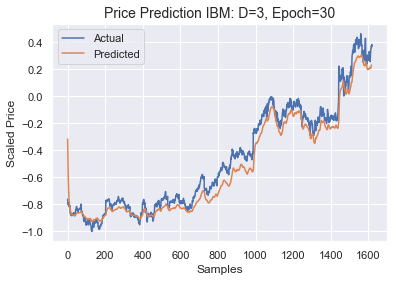

Saving image to: plots/ibmD3_E29.0.png


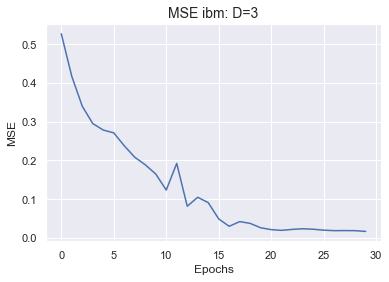

In [14]:
# Instantiate Visualization Helper
viz = VizHelp()
y_train_np = y_train.cpu().detach().numpy()
y_pred_np = y_pred.cpu().detach().numpy()
viz.plotPredictions(y_pred_np, y_train_np, decoder_steps, num_epochs, input_path)
name = input_files[file_idx].split('.')[0]
viz.plotMSE(errors, decoder_steps, 1, name)

In [39]:
# Append-adds at last 
file1 = open("results.txt", "a")  # append mode 
file1.write(f'{name}\t{decoder_steps}\t\t{errors[-1]}\t{num_epochs}\n')
file1.close() 